# Have the Conservatives Moved Left?

In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
dataset_name = "W16_comb"
df_list = [ "BES_Panel", ]

In [3]:
%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

In [4]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )

In [95]:
def weighted_mean(x, **kws):
    val, weight = map(np.asarray, zip(*x))
    return (val * weight).sum() / weight.sum()

In [62]:
max_wave = int(re.match("W(\d+)_",dataset_name).groups()[0])
num_to_wave = {x:"W"+str(x) for x in range(1,max_wave+1)}
wts_for_wave = { "W"+str(y):[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,max_wave+1) }
# wts_for_wave

In [7]:
df = pd.Series([re.match("(.*?)($|W\d+)",x).groups()[0] for x in BES_Panel.columns]).value_counts()
df

wt_new_                     33
wt_full_                    25
bestOnMII                   16
likeSNP                     16
likeLD                      16
                            ..
labPriorities2_immig         1
automationEffectsCountry     1
noDealResults_5              1
resourceAccess3_8            1
myPartyWon                   1
Length: 1918, dtype: int64

In [25]:
BES_Panel["goodTimePurchaseW8"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
92582    NaN
92583    NaN
92584    NaN
92585    NaN
92586    NaN
Name: goodTimePurchaseW8, Length: 92587, dtype: category
Categories (4, object): [Bad time to buy, Don't know, Good time to buy, Neither good nor bad time to buy]

In [30]:
drop_list = ["starttime","endtime","bestOnMII","mii","wt_full_","wt_new_","pano","pcon"]
df[df==10].drop(drop_list,errors='ignore').sort_index()

age                  10
dutyToVote2          10
euID                 10
euID1                10
euID2                10
euID3                10
euID4                10
euID6                10
euID7                10
europeanness         10
gor                  10
headHouseholdPast    10
immigCon             10
immigGreen           10
immigLD              10
immigLab             10
immigPC              10
immigSNP             10
immigSelf            10
immigUKIP            10
likeCorbyn           10
referendumSettled    10
snpUnited            10
dtype: int64

In [ ]:
np.unique([x.split("W")[0] for x in search(BES_Panel,".*Con(W|$)",case_sensitive=True).index])

In [5]:
# np.unique([x.split("W")[0] for x in search(BES_Panel,".*Con",case_sensitive=True).index])

In [9]:
# StrongLeader W10W11W14W15W16
# like<Leader>/<party>
# ptv<party>
# partyId(/Squeeze/Strength),generalElectionVote,bestOnMII,leftRight
# <party>United
# EUIntegration<party>

# 14
# britishness,scottishness,welshness,
# econGenRetro, econPersonalRetro
# turnoutUKGeneral, education

# 13
# partyContact
# mii_cat, LRAL_mii_cat, small_mii_cat
# changeEconomy, goodTimePurchase, polAttention, satDem(Eng/Scot/UK/Wales), riskPoverty, riskUnemployment
# scotReferendumIntention
# lr<party>, redist<party>

# 12
# change(Education/NHS)
# efficacy(NotUnderstand/PolCare/TooMuchEffort/Understand)
# immig(Cultural/Economy)
# trustMPs

# 11
# pid<features>
# change(CostLive/Crime/Immig)
# approve(ScotGovt/UKGovt/WelshGovt)


In [53]:
# fix order of redist cats
redist_cats = BES_Panel["redistConW16"].cat.categories

BES_Panel[match(BES_Panel,"redist").index] = \
    BES_Panel[match(BES_Panel,"redist").index]\
        .apply(lambda x: x.cat.reorder_categories(redist_cats))

In [150]:
%%time

df=pd.DataFrame()
df2 =pd.DataFrame()
df_wts =pd.DataFrame()

col_name = "subject"
var_name = "redist"
dk_nums = [11,-1]
dk_str = "Don't know"
wave_list = []
redist_vars = pd.Series([re.match(var_name+"([a-zA-Z]*)($|W\d+)",x).groups()[0] for x in BES_Panel.columns if re.match("("+var_name+"[a-zA-Z]*)($|W\d+)",x)]).value_counts()
redist_vars = redist_vars[redist_vars>2].index

for subj in redist_vars:
    for wave in ["W"+str(x) for x in range(1,17)]:
        if var_name+subj+wave not in BES_Panel.columns:
            continue
        else:
            wave_list.append(wave)
        df[var_name+"num_"+subj+"_"+wave] = BES_Panel[var_name+subj+wave].cat.codes.replace(dk_nums,[np.nan for x in range(0,len(dk_nums))])
        df2[var_name+"dk"+subj+"_"+wave] = BES_Panel[var_name+subj+wave]==dk_str
for wave in pd.unique(wave_list):        
    df_wts["wt_"+wave] = BES_Panel[wts_for_wave[wave]]
    
df_wts = df_wts[df.notnull().any(axis=1)]
df = df[df.notnull().any(axis=1)]

df2.columns = df2.columns.str.split('_', expand=True)
df2 = df2.stack(dropna=False)\
            .reset_index()\
            .rename(columns={'level_1':"wave"})\
            .rename(columns={'level_0':"id"}) 

df_wts.columns = df_wts.columns.str.split('_', expand=True)
df_wts = df_wts.stack(dropna=False)\
            .reset_index()\
            .rename(columns={'level_1':"wave"})\
            .rename(columns={'level_0':"id"}) 

df.columns = df.columns.str.split('_', expand=True)
df = df.stack(dropna=False)\
        .reset_index()\
        .rename(columns={'level_1':"wave"})\
        .rename(columns={'level_0':"id"}) 

df["wt"] = df_wts["wt"]
df = df.loc[ df[[x for x in df.columns if var_name+"num" in x]].notnull().any(axis=1) ]
df.loc[:,"wt"] = df.loc[:,"wt"].fillna(1.0).values
temp_ind_name = "temp_index"
df[temp_ind_name] = list(zip(df["wave"],df["wt"]))
df = df.set_index(temp_ind_name).drop(["id","wave","wt"],axis=1)

df2["wt"] = df_wts["wt"]
df2 = df2.loc[ df2[[x for x in df2.columns if var_name+"dk" in x]].notnull().any(axis=1) ]
df2.loc[:,"wt"] = df2.loc[:,"wt"].fillna(1.0).values
temp_ind_name = "temp_index"
df2[temp_ind_name] = list(zip(df2["wave"],df2["wt"]))
df2 = df2.set_index(temp_ind_name).drop(["id","wave","wt"],axis=1)


flat_df_num = df.stack().reset_index().rename(columns={'level_1':col_name})
flat_df_num["wave"] = flat_df_num[temp_ind_name].apply(lambda x:int(x[0].split("W")[1]))
flat_df_num["wt"] = flat_df_num[temp_ind_name].apply(lambda x:x[1])
flat_df_num.drop(temp_ind_name,axis=1,inplace=True)
flat_df_num[col_name] = flat_df_num[col_name].astype('category')

flat_df_num[var_name+"_wts"] = list(zip(flat_df_num[var_name+"num"],flat_df_num["wt"]))



Wall time: 7.99 s


In [83]:
g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=3);
g.map(sns.lineplot, "wave",var_name+"_wts", estimator=weighted_mean,ci=None);

In [156]:
flat_df_dk = df2.stack().reset_index().rename(columns={'level_1':col_name+"_dk",0:"dk"})
flat_df_dk["wave"] = flat_df_dk[temp_ind_name].apply(lambda x:int(x[0].split("W")[1]))
flat_df_dk["wt"] = flat_df_dk[temp_ind_name].apply(lambda x:x[1])
flat_df_dk.drop(temp_ind_name,axis=1,inplace=True)
flat_df_dk["dk"] = flat_df_dk["dk"].astype('int')


In [159]:
flat_df_dk.groupby(["wave","subject_dk"]).apply(lambda x: (x["wt"]*x["dk"]).sum()/x["wt"].sum() ).

wave  subject_dk  
1     redistdkCon     0.068858
      redistdkLD      0.079533
      redistdkLab     0.069447
      redistdkPC      0.013867
      redistdkSNP     0.015547
                        ...   
16    redistdkLab     0.130348
      redistdkPC      0.011931
      redistdkSNP     0.013793
      redistdkSelf    0.054453
      redistdkUKIP    0.207364
Length: 103, dtype: float64

Wall time: 1min 42s


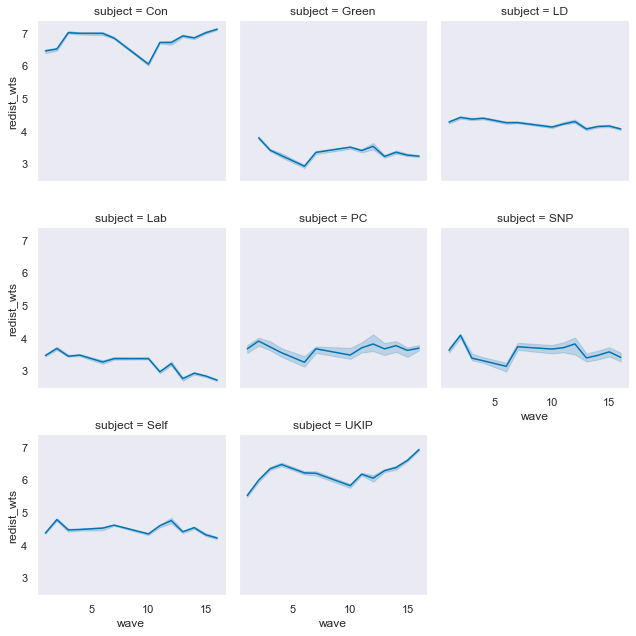

In [85]:
%%time

g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=3);
g.map(sns.lineplot, "wave",var_name+"_wts", estimator=weighted_mean,n_boot=20);

Wall time: 17.6 s


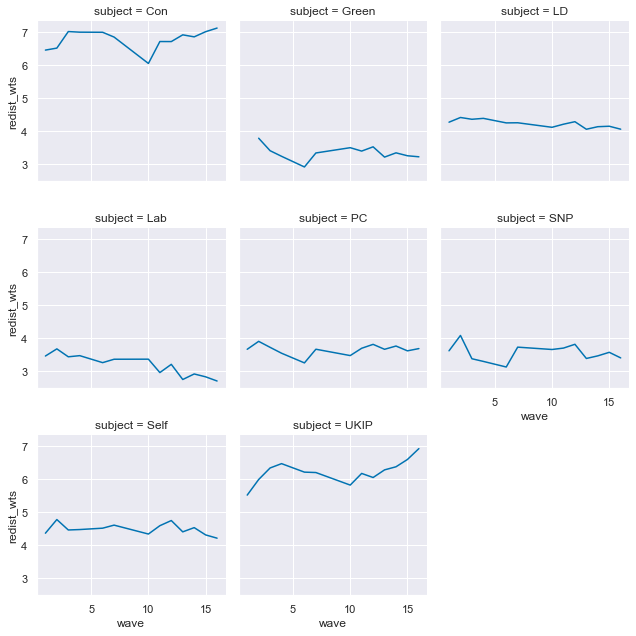

In [88]:
%%time
# plt.rcParams["axes.grid"] = True
g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=3);
g.map(sns.lineplot, "wave",var_name+"_wts", estimator=weighted_mean,ci=None);

In [ ]:
%%time

g = sns.FacetGrid(data=flat_df_num.sample(replace=True,weights="wt",axis=0,frac=1),
                  col="subject", col_wrap=3);
g.map(sns.lineplot, "wave","redist_num", ci=90);